In [1]:
pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------- ------ 524.3/625.1 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.7 MB 5.6 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.7 MB 4.4 MB/s eta 0:00:01
   -------------------------------------- - 2.6/2.7 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 4.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.8 MB 5.6 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/12.8 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.9/12.8 MB 5.1 MB/s eta 0:00:02
   ----------- ---------------------------- 3.7/12.8 MB 4.6 MB/s eta 0:00:02
   ------------- -

In [6]:
!pip install holidays
!pip install plotly
!pip install xgboost
!pip install matplotlib
!pip install statsmodels scikit-learn
!pip install numpy

  Using cached holidays-0.79-py3-none-any.whl.metadata (47 kB)
Using cached holidays-0.79-py3-none-any.whl (1.2 MB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ------------ --------------------------- 3.1/9.8 MB 23.1 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.8 MB 25.1 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 23.5 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [nar

In [8]:
pip install "numpy<2.0" "pmdarima==2.0.4"

   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ------- -------------------------------- 2.9/15.5 MB 18.6 MB/s eta 0:00:01
   ------------------ --------------------- 7.1/15.5 MB 22.9 MB/s eta 0:00:01
   --------------------------------- ------ 12.8/15.5 MB 22.3 MB/s eta 0:00:01
   ---------------------------------------- 15.5/15.5 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
import os
import holidays
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from typing import Tuple

In [2]:
project_dir = Path(os.getcwd()).parent
data_dir = project_dir / 'data'

In [3]:
from pathlib import Path
import os

data_dir = Path("C:/Users/alejo/OLIST/data")

print("Archivos en la carpeta OLIST:")
print(os.listdir(data_dir))

Archivos en la carpeta OLIST:
['olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv']


In [4]:
orders_df = pd.read_csv(data_dir / 'olist_orders_dataset.csv')
order_items_df = pd.read_csv(data_dir / 'olist_order_items_dataset.csv')

products_df = pd.read_csv(data_dir / 'olist_products_dataset.csv')
category_trans_df = pd.read_csv(data_dir / 'product_category_name_translation.csv')
products_df = products_df.merge(category_trans_df, on='product_category_name', how='left')

customers_df = pd.read_csv(data_dir / 'olist_customers_dataset.csv')
geolocation_df = pd.read_csv(data_dir / 'olist_geolocation_dataset.csv')

# Data Preprocessing

Only looking orders delivered to the customers.

In [5]:
orders_df = orders_df[orders_df['order_status'] == 'delivered'].drop(['order_status'], axis=1)

Join orders, order_item, and product datasets to get a holistic view of products and orders

In [6]:
data_df = orders_df.merge(order_items_df, on='order_id').merge(products_df, on='product_id')[[
    'order_purchase_timestamp',
    'order_id',
    'seller_id',
    'product_id',
    'product_category_name_english',
    'order_item_id',
    'price',
    'freight_value',
]]

In [7]:
print(data_df.columns.tolist())

['order_purchase_timestamp', 'order_id', 'seller_id', 'product_id', 'product_category_name_english', 'order_item_id', 'price', 'freight_value']


In [8]:
#Renombrar
data_df = data_df.rename(columns={
    'order_purchase_timestamp': 'order_date',
    'product_category_name_english': 'product_category',
    'order_item_id': 'quantity'
})

Get the final price paid by the customer.

In [9]:
data_df['value'] = data_df['price'] + data_df['freight_value']
data_df['value'] = data_df['value'] * data_df['quantity']

In [10]:
print(data_df.columns.tolist())

['order_date', 'order_id', 'seller_id', 'product_id', 'product_category', 'quantity', 'price', 'freight_value', 'value']


In [11]:
#Elimina columnas innecesarias
data_df.drop(['price', 'freight_value', 'quantity'], axis=1, inplace=True)

In [12]:
print(data_df.columns.tolist())

['order_date', 'order_id', 'seller_id', 'product_id', 'product_category', 'value']


Typecast string dates to datetime format.

In [13]:
data_df['order_date'] = pd.to_datetime(data_df['order_date'])

Some product categories are duplicate or represent the same thing. So we merge them for simplicity.

In [14]:
def merge_categories(cat: str):
    result = cat
    if cat == 'home_appliances_2':
        result = 'home_appliances'
    elif cat == 'home_comfort_2':
        result = 'home_comfort'
    elif cat == 'home_confort':
        result = 'home_comfort'
    return result

data_df['product_category'] = data_df['product_category'].apply(merge_categories)

In [15]:
data_df.dropna(inplace=True)

Add holidays column. Additionally marking Black Friday as a holiday. Having holiday information directly correlates with more demand and more sale in E-commerce industry.

In [16]:
br_holidays = holidays.country_holidays('BR', years=[2016, 2017, 2018], observed=False)

In [17]:
br_holidays[datetime(2017, 11, 24)] = 'Black Friday'

In [18]:
data_df['is_holiday'] = data_df['order_date'].apply(lambda x: 1 if x.date() in br_holidays else 0)


In [19]:
data_df.head()

,order_date,order_id,seller_id,product_id,product_category,value,is_holiday
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,housewares,38.71,0
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,perfumery,141.46,0
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,auto,179.12,0
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,72.20,0
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,stationery,28.62,0


In [20]:
data_df.isnull().sum()

order_date          0
order_id            0
seller_id           0
product_id          0
product_category    0
value               0
is_holiday          0
dtype: int64

In [21]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108638 entries, 0 to 110196
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_date        108638 non-null  datetime64[ns]
 1   order_id          108638 non-null  object        
 2   seller_id         108638 non-null  object        
 3   product_id        108638 non-null  object        
 4   product_category  108638 non-null  object        
 5   value             108638 non-null  float64       
 6   is_holiday        108638 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 6.6+ MB


# Daily Sales Forecast

In [22]:
sales_df = data_df[['order_date', 'is_holiday', 'value']] # selecting only the columns we need
sales_df.set_index('order_date', inplace=True) # setting the index to be the date

sales_df.rename({'value': 'sales'}, axis=1, inplace=True) # renaming the column to 'sales'

sales_df.sort_index(inplace=True) # sorting the dataframe by the index
sales_df = sales_df.resample('D').sum() # resample to daily sales

sales_df.dropna(inplace=True)

C:\Users\alejo\AppData\Local\Temp\ipykernel_19536\1348213527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.rename({'value': 'sales'}, axis=1, inplace=True) # renaming the column to 'sales'
C:\Users\alejo\AppData\Local\Temp\ipykernel_19536\1348213527.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.sort_index(inplace=True) # sorting the dataframe by the index


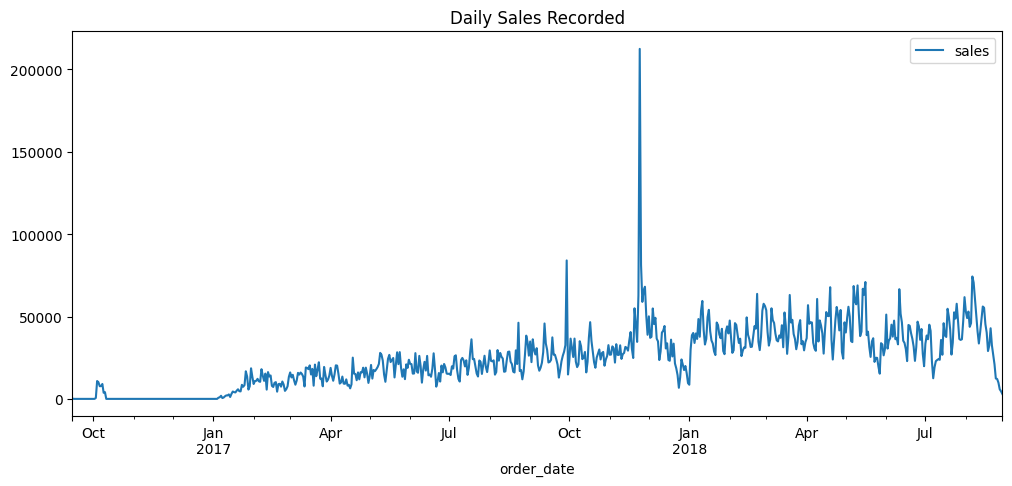

In [23]:
sales_df['sales'].plot(figsize=(12, 5))
plt.title(f'Daily Sales Recorded')
plt.legend()
plt.show()

Dropping data for all the points from Oct 2016 to Jan 2017 as there isn't any recorded data.
The day with Max Sales is 24th Nov 2017 - Black Friday (Outlier Event)
There also appears a small trend and daily seasonality in sales.

Check Stationarity in the sales data using Augumented Dicky-fuller test.

In [24]:
def is_stationary(series: pd.Series, sig_level=0.05) -> bool:
    '''
    Perform Augmented Dickey-Fuller test to check if the series is stationary.
    If p-value is less than the significance level, we reject the null hypothesis and infer that the series is stationary.
    '''
    result = adfuller(series)
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return True if p_value < sig_level else False

In [25]:
print(f'Is Stationary: {is_stationary(sales_df["sales"])}')


ADF Statistic: -2.459667617000628
p-value: 0.1255984903345832
Is Stationary: False


In [26]:
# Corregir estacionariedad
sales_diff = sales_df['sales'].diff().dropna()


In [27]:
result = adfuller(sales_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -8.305225107742071
p-value: 3.920147302944884e-13


La serie tiene una sola raíz unitaria

# ETS Decomposition.Descomposicion estacional

Check Trend and Seasonality in the sales data

In [28]:
decomposition = seasonal_decompose(sales_df['sales'], model='additive', period=7)


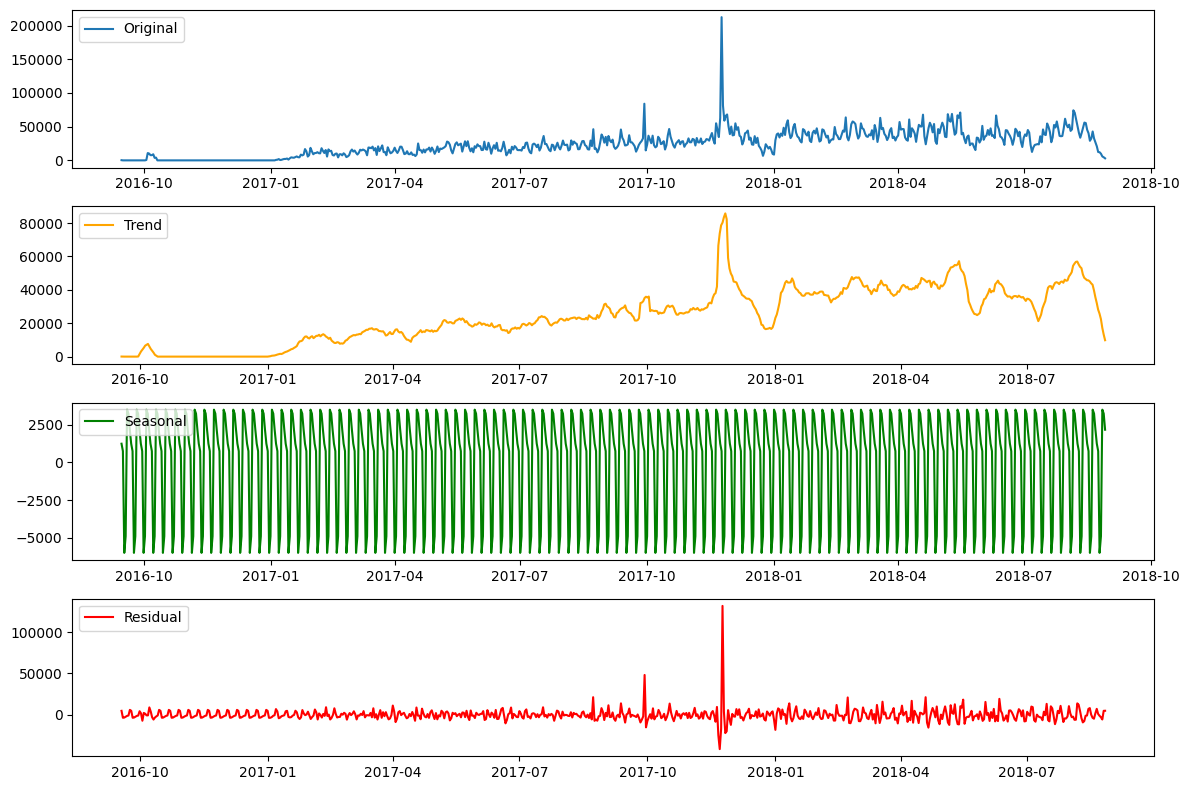

In [29]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(sales_df['sales'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

<Axes: xlabel='order_date'>

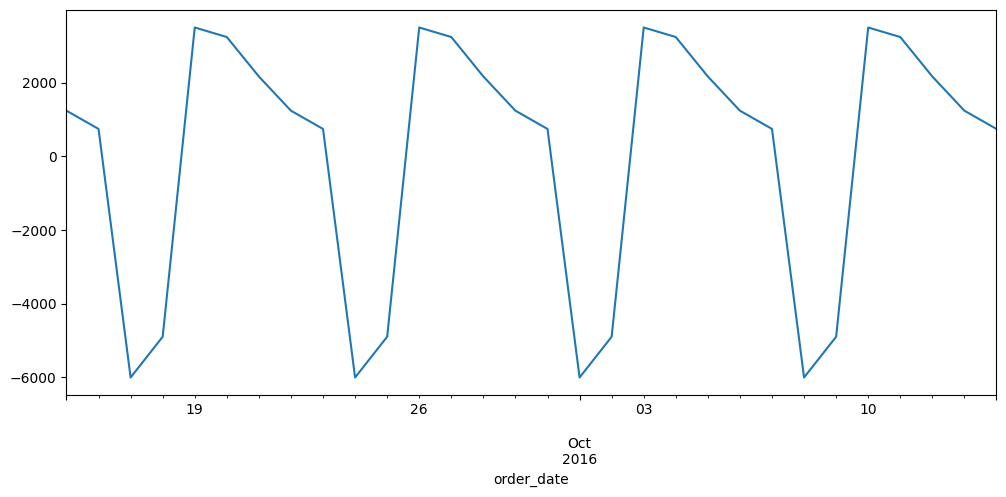

In [30]:
decomposition.seasonal[:30].plot(figsize=(12, 5))


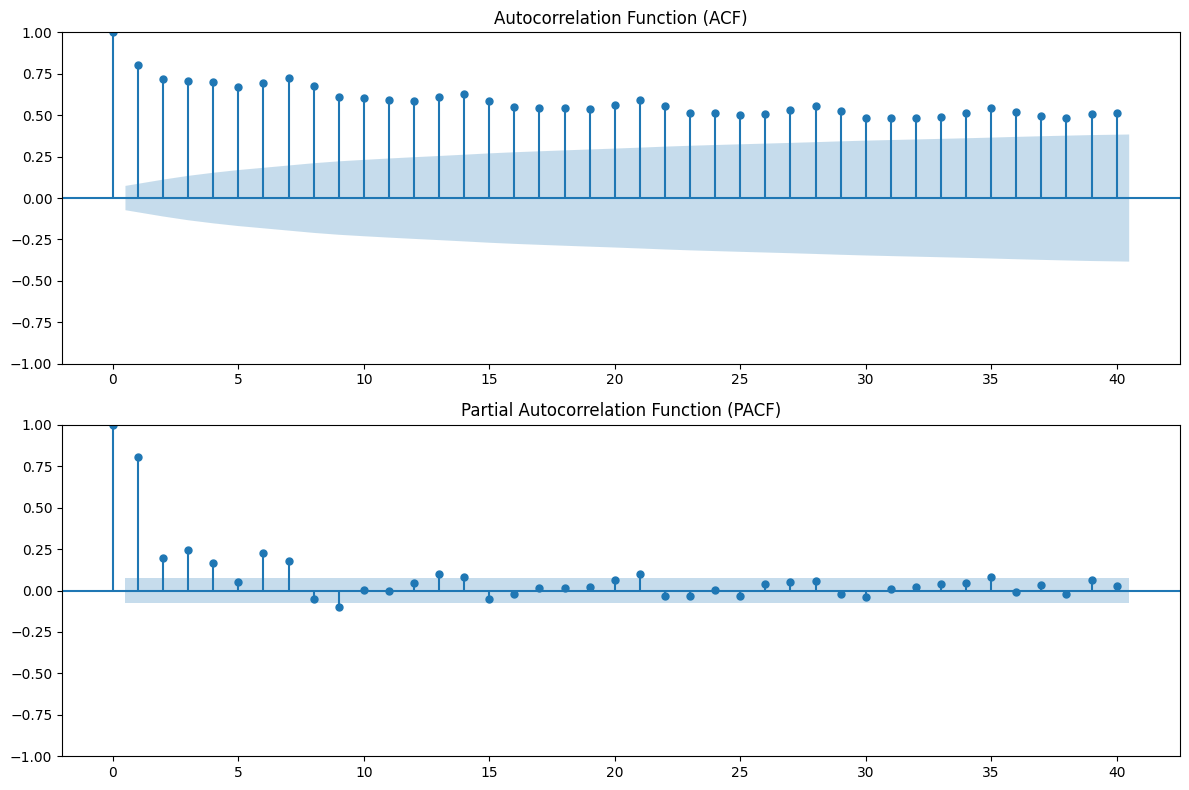

In [31]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(12, 8))

# Autocorrelation Function (ACF)
plot_acf(sales_df['sales'], lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function (PACF)
plot_pacf(sales_df['sales'], lags=40, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Los gráficos ACF y PACF muestran la correlación de una serie temporal con sus propios valores anteriores en los intervalos de tiempo T - 1, T - 2, T - 3, . . . T - n. Estos valores nos ayudan en la etapa de ingeniería de características a finalizar los retrasos que se incluirán como variables predictoras.

El ACF muestra la presencia de una fuerte estacionalidad.
El PACF nos indica que un retraso máximo de 2 sería suficiente.
Sin embargo, a veces puede resultar complicado extraer conclusiones de estos gráficos. Dado que disponemos de mucha capacidad de cálculo, podemos utilizar Auto-ARIMA para entrenar múltiples modelos y seleccionar el mejor con una puntuación AIC baja. De esta manera, podemos identificar el orden correcto de los retrasos para AR y MA.


In [32]:
#Endog variable que se explica por sus propios rezagos. Para explicar y pronosticar las ventas con datos pasados
endog = sales_df['sales']

#Exog variable distinta a la que se quiere medir que puede explicar el comportamiento de las ventas 
exog = sales_df[['is_holiday']]

<Axes: xlabel='order_date'>

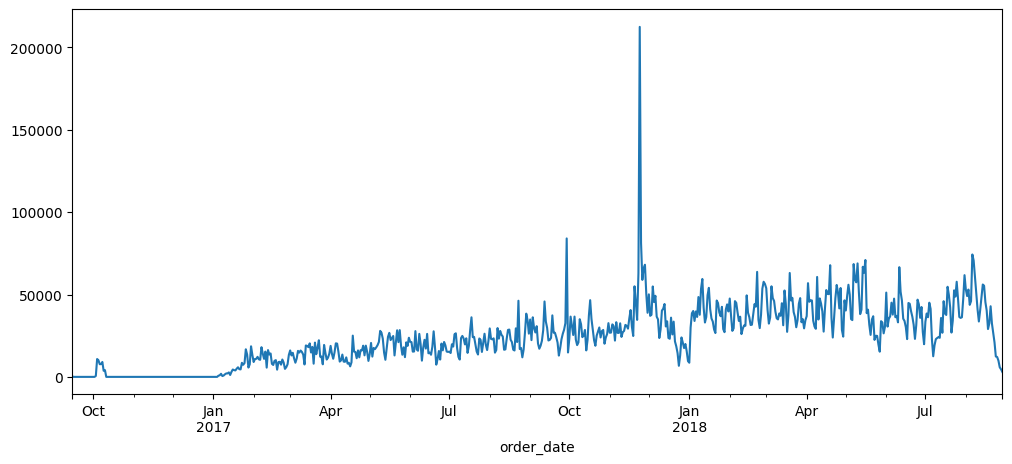

In [33]:
endog.plot(figsize=(12, 5))


In [34]:
is_stationary(endog)

ADF Statistic: -2.459667617000628
p-value: 0.1255984903345832


False

# ENTRENAMIENTO 

In [35]:
#El tamaño del entrenamiento del modelo va a tener el 80% de la muestra
train_size = int(len(endog) * 0.8)

# Data Split esa línea divide tu serie de tiempo y variables externas en train y test.
#Esto es fundamental porque en forecasting siempre entrenas con el pasado y pruebas en datos futuros.
endog_train, endog_test = endog[:train_size], endog[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

In [37]:
auto_model = auto_arima(endog_train,
                        exogenous=exog_train,
                        seasonal=True,
                        m=7,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(f'Optimal order: {auto_model.order}')
print(f'Optimal seasonal order: {auto_model.seasonal_order}')

C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=12105.305, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12279.864, Time=0.05 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12209.269, Time=0.21 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12132.089, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12277.876, Time=0.04 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=12103.713, Time=1.32 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=12116.103, Time=0.94 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=inf, Time=5.14 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=12103.326, Time=1.25 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=12104.114, Time=2.39 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=5.20 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=12105.323, Time=0.83 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=12105.656, Time=0.69 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,0)[7] intercept   : AIC=12104.392, Time=1.69 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,0)[7] intercept   : AIC=12101.871, Time=1.85 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[7] intercept   : AIC=12109.200, Time=0.79 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,0)[7] intercept   : AIC=12102.567, Time=2.78 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[7] intercept   : AIC=12091.905, Time=3.27 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,1)[7] intercept   : AIC=12102.960, Time=1.80 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,1)[7] intercept   : AIC=12095.524, Time=5.41 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,2)[7] intercept   : AIC=12099.168, Time=4.95 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,2)[7] intercept   : AIC=12103.685, Time=2.85 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[7] intercept   : AIC=inf, Time=5.59 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,1)[7] intercept   : AIC=12102.571, Time=1.86 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,1)[7] intercept   : AIC=12094.858, Time=4.74 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(1,0,1)[7] intercept   : AIC=12096.972, Time=3.98 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=12106.798, Time=1.03 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(1,0,1)[7] intercept   : AIC=12103.712, Time=2.43 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=12102.681, Time=3.65 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,0,1)[7] intercept   : AIC=12098.475, Time=4.34 sec


C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[7]             : AIC=inf, Time=3.56 sec

Best model:  ARIMA(2,1,3)(1,0,1)[7] intercept
Total fit time: 77.077 seconds
Optimal order: (2, 1, 3)
Optimal seasonal order: (1, 0, 1, 7)


Best model:  ARIMA(2,1,3)(1,0,1)[7] intercept
ARIMA(2,1,3) → parte no estacional del modelo:

p = 2 → Autorregresivo (usa 2 rezagos).

d = 1 → Se diferenció una vez la serie para volverla estacionaria.

q = 3 → Media móvil (usa 3 rezagos de error).

(1,0,1)[7] → parte estacional del modelo:

P = 1 → Componente autorregresivo estacional.

D = 0 → No se aplicaron diferencias estacionales.

Q = 1 → Componente de media móvil estacional.

[7] → Periodicidad estacional = 7 (ejemplo típico: 7 días en datos diarios → patrón semanal).

intercept → el modelo incluyó un término constante (cuando la diferenciación lo permite).

With the optimal order of AR, MA i.e p & q, let's train a SARIMAX model as we also have holiday as exogenous variable.

# SARIMAX

In [38]:
# Extract optimal parameters
p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order

# Fit the SARIMAX model
sarimax_model = SARIMAX(endog_train,
                        exog=exog_train,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=True,
                        enforce_invertibility=False).fit()

# Print the model summary
print(sarimax_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                  571
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 7)   Log Likelihood               -5848.341
Date:                             Mon, 01 Sep 2025   AIC                          11714.683
Time:                                     07:38:49   BIC                          11753.794
Sample:                                 09-15-2016   HQIC                         11729.943
                                      - 04-08-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday    94.2294      1.300     72.484      0.000      91.681      96.777
ar.L1          0.9197      

C:\Users\alejo\anaconda3\envs\py312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
# Forecast
n_forecast = len(endog_test)
forecast = sarimax_model.get_forecast(steps=n_forecast, exog=exog_test)

# Get confidence intervals
conf_int = forecast.conf_int()

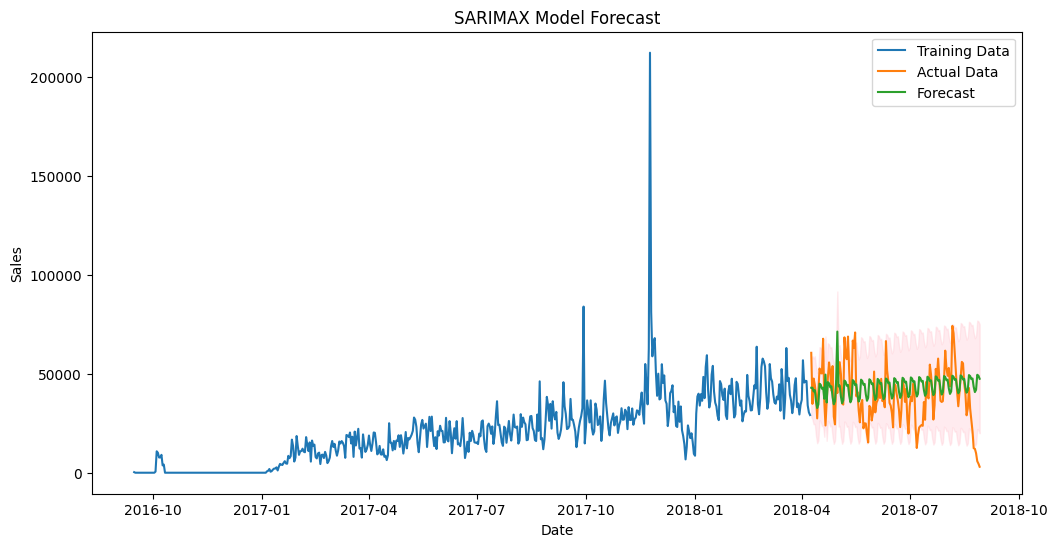

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(endog_train.index, endog_train, label='Training Data')
plt.plot(endog_test.index, endog_test, label='Actual Data')
plt.plot(endog_test.index, forecast.predicted_mean, label='Forecast')
plt.fill_between(endog_test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.show()

In [41]:
#Te dice en promedio cuánto se equivoca el modelo (en las mismas unidades de tu serie).
mae = mean_absolute_error(endog_test, forecast.predicted_mean)

#Penaliza más fuerte los errores grandes (outliers). Es útil cuando quieres ser estricto con predicciones muy desviadas. 👉 Ejemplo: si RMSE = 20, significa que en promedio la desviación de tus predicciones es de 20 unidades.
rmse = np.sqrt(mean_squared_error(endog_test, forecast.predicted_mean))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 10981.949374111657
Root Mean Squared Error: 14389.823085444625


se usa el MAPE (Mean Absolute Percentage Error), que mide el error en porcentaje sobre el valor rea

In [42]:
#El modelo en promedio se equivoca en un 56% respecto al valor real”.

mape = np.mean(np.abs((endog_test - forecast.predicted_mean) / endog_test)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 56.53%


Seems the model has learn't something close to test data but it is not very accurate. Let's try a Machine Learning Approach by training XGBoost model.

# XGBoost

So the optimal order of AR is 2, so we will include two lags. For MA, it is 2 and so a rolling average of 2 is used. Finally no differencing.

In [91]:
# Feature Engineering:

# Lag Features - AR part
sales_df['lag_1'] = sales_df['sales'].shift(1)
sales_df['lag_2'] = sales_df['sales'].shift(2)

# Rolling Statistics Features - MA part Esto imita la parte MA (Moving Average) de un ARIMA, pero como feature explícita en un modelo de Machine Learning.
sales_df['rolling_mean_2'] = sales_df['sales'].rolling(window=2).mean()

# Additional Features
sales_df['day_of_week'] = sales_df.index.dayofweek
sales_df['month'] = sales_df.index.month
sales_df['is_holiday'] = sales_df['is_holiday']

Esto es feature engineering para series temporales.
XGBoost no entiende directamente de rezagos como SARIMA, pero si le das las lags, medias móviles y variables externas, puede aprender patrones muy potentes

In [92]:
sales_features = sales_df.dropna()


In [93]:
#Estoy entrenando un modelo que predice las ventas de hoy (y), basándose en:
#Lo que pasó en los días anteriores (lag_1, lag_2, rolling_mean_2).
#El contexto temporal (day_of_week, month).
#Factores externos (is_holiday).

X = sales_features[['lag_1', 'lag_2', 'rolling_mean_2', 'day_of_week', 'month', 'is_holiday']]
y = sales_features['sales']

In [94]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [95]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 3546.1809366470347


In [97]:
# MAPE
# Para evitar división por cero, agregamos un pequeño epsilon
epsilon = 1e-10
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 5.04%


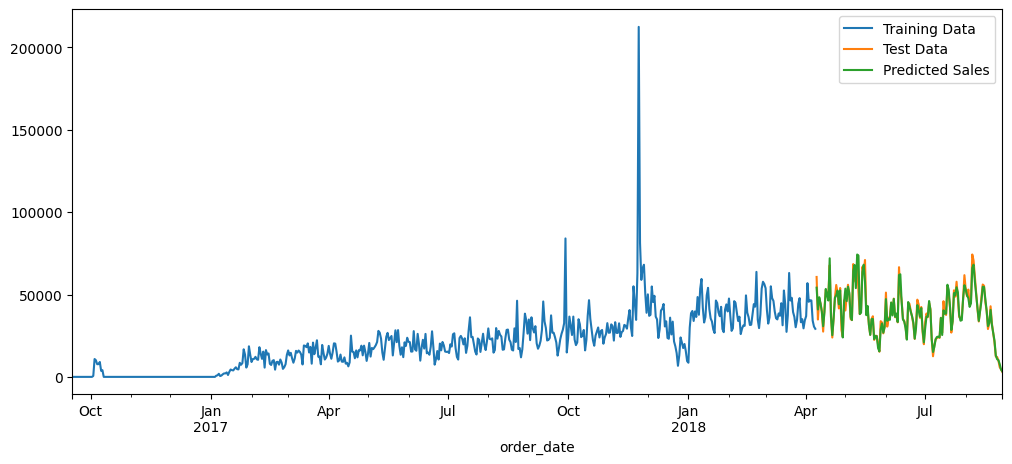

In [96]:
sales_df.loc[X_train.index]['sales'].plot(figsize=(12, 5), label='Training Data')
sales_df.loc[X_test.index]['sales'].plot(label='Test Data')
pd.Series(y_pred, index=y_test.index).plot(figsize=(12, 5), label='Predicted Sales')
plt.legend()
plt.show()

Wow. When compared with SARIMAX, the XGBoost forecasts are much accurate.
The SARIMAX estimates are off by 14,000! However the XGBoost forecasts are only off by 3000!

In [50]:
x = data_df.reset_index().rename({'order_date': 'order_ts'}, axis=1)
x['order_date'] = x['order_ts'].dt.date

In [51]:
x.head()

,index,order_ts,order_id,seller_id,product_id,product_category,value,is_holiday,order_date
0,0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,housewares,38.71,0,2017-10-02
1,1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,perfumery,141.46,0,2018-07-24
2,2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,auto,179.12,0,2018-08-08
3,3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,72.20,0,2017-11-18
4,4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,stationery,28.62,0,2018-02-13


In [59]:
category_demand = x.groupby(['order_date', 'product_category', 'is_holiday']).size().reset_index().rename({0: 'demand'}, axis=1)
category_demand['order_date'] = pd.to_datetime(category_demand['order_date'])

In [60]:
#order_date se convierte en el índice del DataFrame.
category_demand.set_index('order_date', inplace=True)

Drop the categories less than 50 records - hard to compute with less data

In [61]:
x = category_demand['product_category'].value_counts().reset_index()
x = x[x['count'] > 50]
useful_categories = x['product_category'].to_list()
print(f'Number of categories: {len(useful_categories)}')

Number of categories: 56


In [63]:
category_demand = category_demand[category_demand['product_category'].isin(useful_categories)]

In [64]:
category_demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17859 entries, 2016-09-15 to 2018-08-29
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_category  17859 non-null  object
 1   is_holiday        17859 non-null  int64 
 2   demand            17859 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 558.1+ KB


We have a time-series for each of the product category. We have two options for modelling this. Either build multiple individual local models for each product category or build one global model for all the product categories. I choose to train one global model as it is easy to maintain and serve in production than maintaining and deploying a single model for each product category.

To train a global model, we need the dataset to be present in a specific format. Index should be a DateTime Index and each column should represent a product category time series. So we build a pivot table for this.

In [65]:
category_tab_df = pd.pivot_table(category_demand, index=category_demand.index, columns='product_category', values='demand', aggfunc='sum')

In [66]:
category_tab_df['is_holiday'] = category_demand[~category_demand.index.duplicated()]['is_holiday']

In [67]:
category_tab_df.fillna(0, inplace=True)

Resampling for every Day

In [68]:
category_tab_df = category_tab_df.resample('D').sum()

In [69]:
category_tab_df.head()

product_category,agro_industry_and_commerce,air_conditioning,art,audio,auto,baby,bed_bath_table,books_general_interest,books_technical,christmas_supplies,...,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts,is_holiday
order_date,,,,,,,,,,,,,,,,,,,,,
2016-09-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-09-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [70]:
category_tab_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 714 entries, 2016-09-15 to 2018-08-29
Freq: D
Data columns (total 57 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   agro_industry_and_commerce               714 non-null    float64
 1   air_conditioning                         714 non-null    float64
 2   art                                      714 non-null    float64
 3   audio                                    714 non-null    float64
 4   auto                                     714 non-null    float64
 5   baby                                     714 non-null    float64
 6   bed_bath_table                           714 non-null    float64
 7   books_general_interest                   714 non-null    float64
 8   books_technical                          714 non-null    float64
 9   christmas_supplies                       714 non-null    float64
 10  cine_photo             

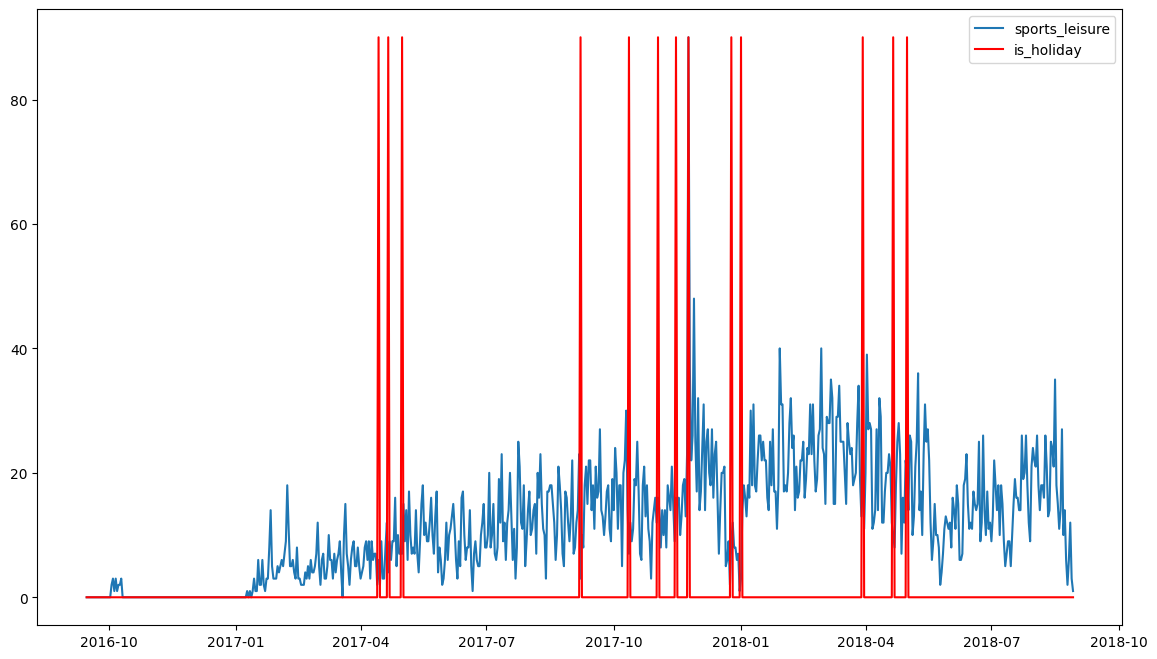

In [71]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(category_tab_df['sports_leisure'], label='sports_leisure')
ax.plot(category_tab_df['is_holiday']*category_tab_df['sports_leisure'].max(), color='red', label='is_holiday')
plt.legend()
plt.show()

In [72]:
def adf_test(series: pd.Series):
    result = adfuller(series)
    p_value = result[1]
    return p_value

Checking the stationarity of each product category time series

In [73]:
for cat in category_tab_df.columns[:-1]:
    p_value = adf_test(category_tab_df[cat])
    print(f'{cat}: {p_value} | is_stationary: {p_value < 0.05}')

agro_industry_and_commerce: 0.0031052690470655827 | is_stationary: True
air_conditioning: 6.368715658436335e-09 | is_stationary: True
art: 0.03091760694462296 | is_stationary: True
audio: 0.002027495367938099 | is_stationary: True
auto: 0.24748264232213746 | is_stationary: False
baby: 0.12226866721528679 | is_stationary: False
bed_bath_table: 0.004587275045390232 | is_stationary: True
books_general_interest: 0.02307491259332083 | is_stationary: True
books_technical: 0.0889488615778164 | is_stationary: False
christmas_supplies: 0.03590477046132695 | is_stationary: True
cine_photo: 7.111350438692679e-07 | is_stationary: True
computers: 1.231473985147966e-07 | is_stationary: True
computers_accessories: 0.2613671658434692 | is_stationary: False
consoles_games: 0.0006356400411409468 | is_stationary: True
construction_tools_construction: 0.6837633037271906 | is_stationary: False
construction_tools_lights: 0.5770638033361782 | is_stationary: False
construction_tools_safety: 0.1049631859559972

Building Lags and Rolling Statistics for each category and using them as features.

In [74]:
def feature_engineering(
        data: pd.DataFrame, p: int, q: int, 
        day_of_week: bool = True, 
        month: bool = True, 
        is_weekend: bool = True,
        test_size: float = 0.2
        ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Create Time Series Features for Model Training. Asssumption is that the data is indexed by date.
    :param p: Number of lags to include
    :param q: Window size for rolling mean
    '''
    df = data.copy(deep=True)
    prod_categories = df.columns[:-1]

    if day_of_week:
        df['day_of_week'] = df.index.dayofweek
    if month:
        df['month'] = df.index.month
    if is_weekend:
        df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    for cat in prod_categories:
        for lag in range(1, p + 1):
            df[f'{cat}_lag_{lag}'] = df[cat].shift(lag)

        df[f'{cat}_rolling_mean_{q}'] = df[cat].rolling(window=q).mean()
    
    df.dropna(inplace=True)

    X = df.drop(prod_categories, axis=1)
    y = df[prod_categories]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    return X_train, X_test, y_train, y_test


In [75]:
#La idea de poner p=2 y q=2 es capturar dependencias cortas en el tiempo: 
#Cómo influye lo ocurrido en los últimos 1–2 días en la predicción de hoy.
#Cómo una pequeña tendencia (media de 2 días) afecta la predicción.
X_train, X_test, y_train, y_test = feature_engineering(data=category_tab_df, p=2, q=2)

C:\Users\alejo\AppData\Local\Temp\ipykernel_19536\1268949763.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{cat}_rolling_mean_{q}'] = df[cat].rolling(window=q).mean()
C:\Users\alejo\AppData\Local\Temp\ipykernel_19536\1268949763.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{cat}_lag_{lag}'] = df[cat].shift(lag)
C:\Users\alejo\AppData\Local\Temp\ipykernel_19536\1268949763.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [76]:
#validar dimensiones y columnas creadas:
#Con eso confirmas qué columnas de features se generaron (ejemplo: sports_leisure_lag_1, sports_leisure_rolling_mean_2, etc.) y cuántas filas se eliminaron por los NaN iniciales.
print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("\nEjemplo de features:")
print(X_train.head())

Shapes:
X_train: (569, 172)
X_test: (143, 172)
y_train: (569, 56)
y_test: (143, 56)

Ejemplo de features:
product_category  is_holiday  day_of_week  month  is_weekend  \
order_date                                                     
2016-09-17                 0            5      9           1   
2016-09-18                 0            6      9           1   
2016-09-19                 0            0      9           0   
2016-09-20                 0            1      9           0   
2016-09-21                 0            2      9           0   

product_category  agro_industry_and_commerce_lag_1  \
order_date                                           
2016-09-17                                     0.0   
2016-09-18                                     0.0   
2016-09-19                                     0.0   
2016-09-20                                     0.0   
2016-09-21                                     0.0   

product_category  agro_industry_and_commerce_lag_2  \
order_date  

In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 569 entries, 2016-09-17 to 2018-04-08
Freq: D
Columns: 172 entries, is_holiday to watches_gifts_rolling_mean_2
dtypes: float64(168), int32(2), int64(2)
memory usage: 764.6 KB


We have 172 predictors (in total) and 569 time samples.

In [78]:
#Entrenando un modelo XGBoost para predecir la demanda de todas las categorías a la vez.
#XGBRegressor → modelo de regresión basado en árboles de decisión (boosting).
#objective="reg:squarederror" → indica que el objetivo es minimizar el error cuadrático medio (MSE).
#n_estimators=100 → número de árboles a entrenar.
#max_depth=5 → profundidad máxima de cada árbol (regularización para evitar sobreajuste).
#learning_rate=0.1 → paso de aprendizaje; controla cuánto corrige cada árbol al modelo global
model = XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [79]:
#Evaluando el desempeño del modelo XGBoost en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.7531201612436356


Ese valor de RMSE ≈ 1.75 significa que, en promedio, la predicción del modelo XGBoost para la demanda de cada categoría diaria se desvía 1.75 unidades respecto a la demanda real.

Forecasting for next 7 days

In [80]:
n_steps = 7
recent_data = X_train.tail(1).copy(deep=True)
prediction_columns = y_train.columns
forecast = pd.DataFrame(columns=prediction_columns)

for i in range(n_steps):
    prev_day = recent_data.tail(1)
    #reshape(1, -1) transforma tu vector 1D en una matriz 2D de 1 fila y muchas columnas, para que el modelo lo entienda como “un registro con varias variables”.
    prev_day_data = prev_day.values.reshape(1, -1)
    prev_date = prev_day.index[0]

    prediction_value = model.predict(prev_day_data)
    prediction_date = prev_date + pd.DateOffset(days=1)
    prediction_row = pd.DataFrame(prediction_value, index=[prediction_date], columns=prediction_columns)
    forecast = pd.concat([forecast, prediction_row], axis=0)

    new_rec = {i: 0 for i in prev_day.columns}
    new_rec['day_of_week'] = prediction_date.dayofweek
    new_rec['month'] = prediction_date.month
    new_rec['is_weekend'] = 1 if new_rec['day_of_week'] >= 5 else 0

    # prev day's lag 1 is new rec's lag 2
    for cat in prediction_columns:
        new_rec[f'{cat}_lag_2'] = prev_day[f'{cat}_lag_1'].values[0]
        new_rec[f'{cat}_lag_1'] = prediction_row.iloc[0][cat]
        new_rec[f'{cat}_rolling_mean_2'] = np.mean([new_rec[f'{cat}_lag_2'], new_rec[f'{cat}_lag_1']])
    
    recent_data = pd.concat([recent_data, pd.DataFrame(new_rec, index=[prediction_date])], axis=0)

C:\Users\alejo\AppData\Local\Temp\ipykernel_19536\2444214171.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  forecast = pd.concat([forecast, prediction_row], axis=0)
C:\Users\alejo\AppData\Local\Temp\ipykernel_19536\2444214171.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast = pd.concat([forecast, prediction_row], axis=0)


Se hace predicción día por día para 7 días.

Cada predicción se convierte en input para el siguiente día.

Se actualizan los lags y rolling mean dinámicamente.

Al final, forecast tendrá las 7 predicciones para todas las categorías.

In [81]:
forecast

product_category,agro_industry_and_commerce,air_conditioning,art,audio,auto,baby,bed_bath_table,books_general_interest,books_technical,christmas_supplies,...,pet_shop,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
2018-04-09,0.000185,0.000125,1.997378,0.000257,4.968965,6.986967,30.025318,0.999284,-0.000017,0.000141,...,4.002950,0.000111,3.998707,0.000058,14.257848,0.025041,0.000079,4.997171,2.995108,9.766434
2018-04-10,0.000168,0.000125,0.000617,0.000302,10.755862,3.991482,22.986111,0.998598,-0.000510,0.000141,...,4.051684,0.000111,3.893015,0.000058,12.674479,-0.036762,0.000076,7.856422,4.065028,9.022528
2018-04-11,0.000185,0.000125,0.998914,0.000302,4.836846,7.142305,30.751961,0.998387,-0.000038,0.000141,...,4.070055,0.000111,2.936997,0.000058,14.447546,0.018266,0.000076,4.906593,2.988848,9.128006
2018-04-12,0.000168,0.000125,0.000147,0.000302,11.169631,3.984739,23.416431,0.998598,0.000043,0.000141,...,4.068718,0.000111,4.108199,0.000054,14.676768,-0.008338,0.000076,7.821665,4.967858,9.060717
2018-04-13,0.000185,0.000125,0.000147,0.000302,4.964489,7.972400,31.700312,0.998387,-0.000038,0.000141,...,4.070055,0.000111,2.367194,0.000058,15.154758,0.015623,0.000076,4.906593,2.988848,9.074440
2018-04-14,0.000168,0.000125,0.000147,0.000302,12.601294,3.982289,26.072994,0.998598,0.000043,0.000141,...,4.067242,0.000111,4.796292,0.000054,12.681280,-0.010593,0.000076,7.821665,5.035355,9.078747
2018-04-15,0.000185,0.000125,0.000147,0.000302,5.582227,7.970403,29.858868,0.998387,-0.000038,0.000141,...,4.070055,0.000111,2.370243,0.000058,15.792739,0.019328,0.000076,4.906593,2.837523,9.083116


In [82]:
y_test.loc[forecast.index]
#✅ Resumen conceptual

#Se hace predicción día por día para 7 días.

#Cada predicción se convierte en input para el siguiente día.

#Se actualizan los lags y rolling mean dinámicamente.

#Al final, forecast tendrá las 7 predicciones para todas las categorías.

product_category,agro_industry_and_commerce,air_conditioning,art,audio,auto,baby,bed_bath_table,books_general_interest,books_technical,christmas_supplies,...,pet_shop,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
2018-04-09,0.0,0.0,1.0,3.0,21.0,13.0,23.0,0.0,1.0,0.0,...,8.0,7.0,1.0,0.0,27.0,6.0,0.0,8.0,3.0,9.0
2018-04-10,0.0,1.0,1.0,1.0,9.0,12.0,19.0,0.0,0.0,0.0,...,9.0,0.0,1.0,2.0,14.0,1.0,0.0,2.0,4.0,13.0
2018-04-11,0.0,0.0,0.0,4.0,14.0,9.0,34.0,0.0,0.0,0.0,...,6.0,0.0,5.0,0.0,32.0,4.0,0.0,12.0,4.0,12.0
2018-04-12,1.0,0.0,1.0,0.0,13.0,4.0,32.0,5.0,1.0,1.0,...,5.0,4.0,5.0,1.0,29.0,6.0,0.0,26.0,5.0,10.0
2018-04-13,1.0,1.0,0.0,0.0,11.0,7.0,30.0,1.0,1.0,0.0,...,5.0,0.0,1.0,0.0,12.0,7.0,0.0,6.0,7.0,12.0
2018-04-14,0.0,0.0,0.0,1.0,7.0,7.0,17.0,0.0,0.0,0.0,...,3.0,2.0,5.0,0.0,12.0,3.0,0.0,6.0,1.0,11.0
2018-04-15,0.0,2.0,1.0,1.0,12.0,13.0,24.0,0.0,0.0,0.0,...,3.0,0.0,2.0,0.0,17.0,11.0,0.0,11.0,3.0,7.0


In [83]:
category_wise_rmse = {}

expected = y_test.loc[forecast.index]
for cat in forecast.columns:
    category_wise_rmse[cat] = np.sqrt(mean_squared_error(expected[cat], forecast[cat]))

In [85]:
sorted(category_wise_rmse.items(), key=lambda x: x[1], reverse=True)

[('sports_leisure', 9.92282490034675),
 ('furniture_decor', 9.28815988112212),
 ('housewares', 8.582231428292086),
 ('telephony', 8.156737491824304),
 ('auto', 8.074478912668367),
 ('computers_accessories', 7.288585959122766),
 ('health_beauty', 7.03815392256089),
 ('bed_bath_table', 6.199172709944298),
 ('stationery', 6.177721461559922),
 ('electronics', 5.364849629367309),
 ('cool_stuff', 5.246866105370808),
 ('home_appliances', 5.051125766051152),
 ('office_furniture', 5.003840081765934),
 ('baby', 4.45762876159166),
 ('drinks', 4.070885586679293),
 ('home_construction', 3.6433904605875425),
 ('fashion_bags_accessories', 3.601448241503616),
 ('signaling_and_security', 3.1395428357740003),
 ('construction_tools_lights', 2.9279479123548082),
 ('construction_tools_construction', 2.8727610957236616),
 ('perfumery', 2.8250746599810017),
 ('pet_shop', 2.6241470061008614),
 ('garden_tools', 2.5683136427383553),
 ('watches_gifts', 2.453213494824582),
 ('toys', 2.185260575915814),
 ('audio',

Observaciones

Hay un rango muy amplio: de ~0.00008 hasta ~9.9.

Esto refleja que algunas categorías son difíciles de predecir porque tienen patrones de venta más impredecibles o más días con picos altos.

Categorías con RMSE < 1 → muy confiables.

Categorías con RMSE > 5 → el modelo podría necesitar mejor feature engineering o más datos históricos.

In [86]:
# Evaluate the model calculando el RMSE global del modelo XGBoost para todas las categorías combinadas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.7531201612436356


## Conclusión del Forecasting de Demanda por Categoría

El modelo XGBoost entrenado para predecir la demanda diaria de múltiples categorías alcanzó un RMSE global de 1.75, lo que indica que, en promedio, las predicciones se desvían en menos de 2 unidades de los valores reales, reflejando un desempeño sólido a nivel general. Al analizar el RMSE por categoría, se observó que ciertas categorías con alta variabilidad o picos esporádicos, como sports_leisure, furniture_decor y housewares, presentan errores más elevados (≈8–10), mientras que categorías estables o de baja demanda, como fashion_male_clothing o tablets_printing_image, muestran errores mínimos (≈0–0.4). Esto evidencia que, aunque el modelo captura correctamente los patrones generales, algunas categorías volátiles requieren atención adicional.

En términos prácticos, estas predicciones permiten tomar decisiones informadas de inventario, reposición y planificación de demanda, minimizando pérdidas por sobrestock o desabastecimiento y optimizando la rentabilidad de cada categoría. Para mejorar la precisión en categorías con alta variabilidad, se recomienda incorporar features adicionales, considerar lags más largos, eventos especiales o enfoques híbridos que combinen técnicas como SARIMAX con XGBoost. En conjunto, el modelo representa una herramienta útil y aplicable en la operación diaria, facilitando decisiones basadas en datos y mejorando la eficiencia y utilidades reales del negocio.